In [38]:
import torch
import torch.nn as nn
import torch.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from torchdiffeq import odeint
from torchcontrol.arch import HDNN, HDNN_Observer

In [2]:
if torch.cuda.is_available(): device = torch.device('cuda')

In [3]:
class duffingOscillator(nn.Module):
    def __init__(self, n, w, beta, gamma):
        super().__init__()
        self.J = createJ(n, w, beta, gamma)
    def forward(self, t, xi):
        return torch.matmul(self.J,xi).to(device)

In [4]:
def createJ(n, w, beta, gamma):
    I = torch.eye(n//2)
    M1 = (-w*2-beta)*torch.eye(n//2)
    M2 = (-gamma)*torch.eye(n//2)
    O = torch.zeros((n//2,n//2))
    return torch.cat(((torch.cat((O,I),1)),(torch.cat((M1,M2),1))),0).to(device)

In [5]:
A = createJ(2,1,1,1)
B = createJ(2,1,1,1)
A, B

(tensor([[ 0.,  1.],
         [-3., -1.]], device='cuda:0'), tensor([[ 0.,  1.],
         [-3., -1.]], device='cuda:0'))

In [6]:
osc = duffingOscillator(2,0.5,0.5,0.2)
t = torch.linspace(0,25,100)
xi0 = torch.Tensor([1,0.5]).to(device)
func = osc.forward
sol = odeint(func,xi0,t)

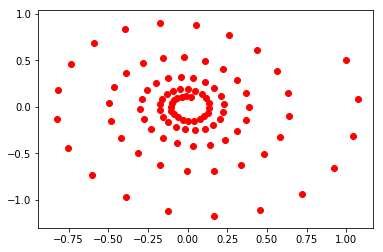

In [7]:
for p in range(len(sol)):
    plt.scatter(sol[p][0].cpu().numpy(),sol[p][1].cpu().numpy(), color='r')

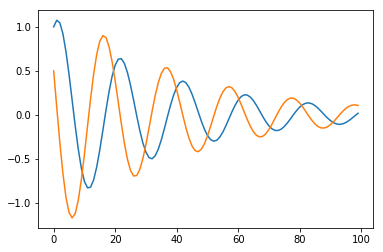

In [8]:
plt.plot(sol.cpu().numpy())

## Create dataset

In [20]:
osc = duffingOscillator(2,0.5,0.5,0.2)
t = torch.linspace(0,7,100)
xi0 = torch.Tensor([1,0.5]).to(device)
func = osc.forward
sol = odeint(func,xi0,t)

In [21]:
labels = sol[1:]

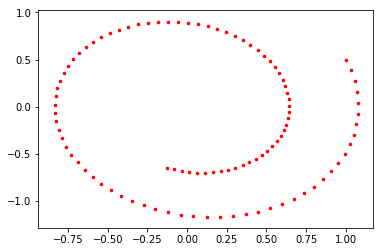

In [22]:
for p in range(len(sol)):
    plt.scatter(sol[p][0].cpu().numpy(),sol[p][1].cpu().numpy(), s=6.5, color='r')

## HDNN observer (access to full state, RNN test)

In [20]:
obs = HDNN_Observer([2,36,2],'MLP',[1,2,0],1, None, False)

In [21]:
x0 = torch.Tensor([1,0.5]).to(device)
x0 = x0.view(1,2)

In [22]:
t = obs.observe(x0, labels, epoch=1, ode_t=1, ode_step=20, time_delta=200)

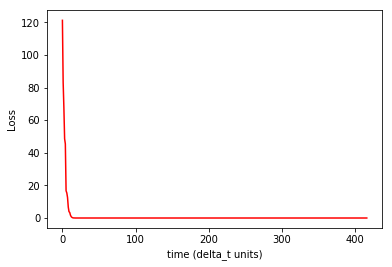

In [23]:
obs.plotLoss()

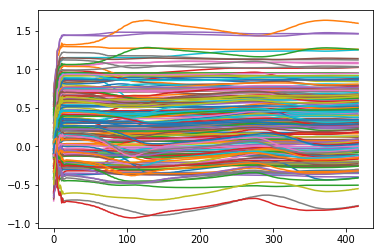

In [24]:
obs.plotParameters()

## Learned trajectory

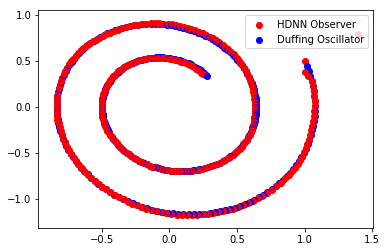

In [27]:
for p in range(len(t)-1):
    plt.scatter(t[p][0][0].cpu().numpy(),t[p][0][1].cpu().numpy(), color='r')
    plt.scatter(labels[p][0].cpu().numpy(),labels[p][1].cpu().numpy(), color='b')
    plt.legend(['HDNN Observer','Duffing Oscillator'])

In [14]:
obs.predictor(x0)

tensor([[-2.9060, -0.0562]], device='cuda:0', grad_fn=<LogSoftmaxBackward>)

# True observation attempt

Only access to position

In [10]:
obs = HDNN_Observer([2,36,2],'MLP',[1,2,0],1, None, False)

In [11]:
x0 = torch.Tensor([1,0.5]).to(device)
x0 = x0.view(1,2)

In [12]:
t = obs.observe(x0, labels, epoch=1, dynamics_delta_t=0.07, ode_t=1, ode_step=20, loss_record_interval=200)

tensor([[ 0.4476, -1.6294]], device='cuda:0') tensor([[1.0000, 0.5000]], device='cuda:0')
tensor([[15.6213, 35.9804]], device='cuda:0') tensor([[-0.0389, -2.2480]], device='cuda:0')
tensor([[-201.9168, -480.9636]], device='cuda:0') tensor([[15.2038, 33.8223]], device='cuda:0')
tensor([[2963.4514, 6522.8125]], device='cuda:0') tensor([[-206.3651, -456.5573]], device='cuda:0')


AssertionError: underflow in dt 0.0

## Dynamics approximation

In [31]:
def createBunch(n):
    labels = {}
    for i in range(10):
        osc = duffingOscillator(2,0.5,0.5,0.2)
        t = torch.linspace(0,7,100)
        xi0 = torch.Tensor(10*torch.randn(2)).to(device)
        func = osc.forward
        sol = odeint(func,xi0,t)
        labels[i] = sol
    return labels

In [32]:
labels = createBunch(10)

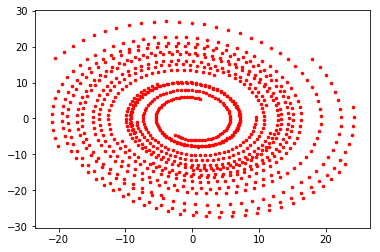

In [33]:
for i in range(len(labels)):
    for p in labels[i]:
        plt.scatter(p[0].cpu().numpy(),p[1].cpu().numpy(), s=6.5, color='r')

In [46]:
init_conditions = [labels[i][0].cpu().numpy() for i in range(len(labels))]

In [47]:
init_conditions

[array([ 12.807344, -14.811664], dtype=float32),
 array([11.6218195, -4.030509 ], dtype=float32),
 array([24.044117 ,  3.0701265], dtype=float32),
 array([-20.484013,  16.75808 ], dtype=float32),
 array([-20.122099 ,  -7.6762238], dtype=float32),
 array([-8.618252 , -3.9037428], dtype=float32),
 array([17.996584, 16.630356], dtype=float32),
 array([ 22.897266, -12.685555], dtype=float32),
 array([9.476784, 0.517673], dtype=float32),
 array([ -4.7023444, -21.230124 ], dtype=float32)]

In [42]:
train = data_utils.TensorDataset([labels[i][0] for i in range(len(labels))],labels)
trainloader = data_utils.DataLoader(train, batch_size=1, shuffle=True)

AttributeError: 'list' object has no attribute 'size'

In [35]:
m = HDNN([2,12,100],'MLP',[1,2,0],1, None, False).to(device)

# barabba

In [15]:
h = [x]
for t in range(100):
    x = obs.predictor(x)
    h.append(x)